In [0]:
import importlib
import subprocess
import sys
from utils.environment_specific import is_local_development


def install_if_missing(package_name, pip_name=None):
    try:
        importlib.import_module(package_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name or package_name])

if not is_local_development():
    install_if_missing("dotenv", "python-dotenv")
    install_if_missing("tldextract")

  Using cached random_string_detector-1.0.3-py3-none-any.whl (24 kB)



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


  Using cached python_dotenv-1.1.0-py3-none-any.whl (20 kB)



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


  Using cached tldextract-5.3.0-py3-none-any.whl (107 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl (4.2 kB)



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from dotenv import load_dotenv

from utils.dataset import (
    load_public_dataset,
    load_full_private_df,
    split_df_by_folds,
    NUMERIC_TO_TEXT_MAPPING,
    NUMERIC_TO_TEXT_MAPPING_KAGGLE_MULTIPLE,
)
from utils.url_features import get_sld

# Load all datasets

In [0]:
datasets = {
    "grambeddings": "grambeddings",
    "kaggle_binary": "kaggle_binary",
    "kaggle_multiple": "kaggle_multiple",
    "mendeley": "mendeley",
    "joined": "joined",
}
dataset_names = datasets.keys()
raw_folder = "./data/raw"
target_folder = "./data/processed"

In [0]:
loaded = load_dotenv(".env")
if not loaded:
    loaded = load_dotenv("../../.env")
assert loaded is True

True

In [0]:
if not is_local_development():
    datasets["private_data"] = "private_data"
else:
    spark = None

In [0]:
def load_dataset(name):
    if name != "private_data":
        df_train, df_test = load_public_dataset(name)
    else:
        df = load_full_private_df(spark)
        df_train, df_test = split_df_by_folds(
            df,
            train_folds=None,
            eval_folds=[4],
            shorten_string_train=None,
            shorten_string_eval=None,
            seed=42,
        )
    return {"train": df_train, "test": df_test}

In [0]:
all_parts = []

for dataset_name in dataset_names:
    splits = load_dataset(dataset_name)
    df_train = splits["train"].copy()
    df_test = splits["test"].copy()

    if dataset_name == "kaggle_multiple":
        num2text = NUMERIC_TO_TEXT_MAPPING_KAGGLE_MULTIPLE
    else:
        num2text = NUMERIC_TO_TEXT_MAPPING
    df_train["label"] = df_train["label"].map(num2text)
    df_test["label"] = df_test["label"].map(num2text)

    df_train["dataset"] = dataset_name
    df_train["set"] = "train"

    df_test["dataset"] = dataset_name
    df_test["set"] = "test"

    all_parts.extend([df_train, df_test])

all_datasets = pd.concat(all_parts, ignore_index=True)
del all_parts

[dataset] Using public dataset grambeddings with path: /Volumes/users/vlavavra/public_datasets/grambeddings
[dataset] Using public dataset kaggle_binary with path: /Volumes/users/vlavavra/public_datasets/kaggle_binary
[dataset] Using public dataset kaggle_multiple with path: /Volumes/users/vlavavra/public_datasets/kaggle_multiple
[dataset] Using public dataset mendeley with path: /Volumes/users/vlavavra/public_datasets/mendeley
[dataset] Using public dataset joined with path: /Volumes/users/vlavavra/public_datasets/joined
[dataset]: All folds [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
[1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan] [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
[4] [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]
[dataset]: train length: 2575879, eval_length: 260281


In [0]:
def get_dataset(dataset_name):
    return all_datasets[all_datasets["dataset"] == dataset_name]

# High level statistics

In [0]:
display(all_datasets.info())
display(all_datasets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9005214 entries, 0 to 9005213
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   url      object 
 1   label    object 
 2   fold     float64
 3   dataset  object 
 4   set      object 
dtypes: float64(1), object(4)
memory usage: 343.5+ MB


url,label,fold,dataset,set
https://blog.sockpuppet.us/,benign,0.0,grambeddings,train
https://blog.apiki.com/seguranca/,benign,3.0,grambeddings,train
http://autoecole-lauriston.com/a/T0RVd056QXlNelF6T1RnPQ==/,malicious,2.0,grambeddings,train
http://chinpay.site/index.html?hgcFSE@E$Z*DFcGVhBiNnikMOJIbhVgTFDRECTFgvBH,malicious,0.0,grambeddings,train
http://www.firstfivenebraska.org/blog/article/covid-19-daily-digest#.XnvphYhKjIU,benign,3.0,grambeddings,train


- The next cell contains datas statistics for each dataset
- TOTAL - all records of a dataset
- %_dataset - how much percent of the current dataset does this class represent
- %_joined_dataset - how much percent of all the datasets joined does this class represent

In [0]:
for name in dataset_names:
    df_subset = all_datasets[all_datasets["dataset"] == name]
    count = df_subset["label"].value_counts()
    percent = (count / len(df_subset) * 100).round(2)
    percent_of_all = (count / len(all_datasets) * 100).round(2)

    summary = pd.DataFrame({"count": count, "%_dataset": percent, "%_total_dataset": percent_of_all})

    total_row = pd.DataFrame(
        {
            "count": [len(df_subset)],
            "%_dataset": [100.0],
            "%_total_dataset": [len(df_subset) / len(all_datasets) * 100],
        },
        index=["TOTAL"],
    )

    summary = pd.concat([summary, total_row])

    print(f"=== Dataset: {name} ===")
    print(summary.round(2))
    print()

=== Dataset: grambeddings ===
            count  %_dataset  %_joined_dataset
benign     399998       50.0              4.44
malicious  399995       50.0              4.44
TOTAL      799993      100.0              8.88

=== Dataset: kaggle_binary ===
            count  %_dataset  %_joined_dataset
benign     316252      56.85              3.51
malicious  240009      43.15              2.67
TOTAL      556261     100.00              6.18

=== Dataset: kaggle_multiple ===
           count  %_dataset  %_joined_dataset
benign    342646      78.47              3.80
phishing   75135      17.21              0.83
malware    18857       4.32              0.21
TOTAL     436638     100.00              4.85

=== Dataset: mendeley ===
             count  %_dataset  %_joined_dataset
benign     1479082      97.69             16.42
malicious    35020       2.31              0.39
TOTAL      1514102     100.00             16.81

=== Dataset: joined ===
             count  %_dataset  %_joined_dataset
benign

# Train / test split

In [0]:
all_datasets["sld"] = all_datasets["url"].apply(get_sld)

In [0]:
for name in dataset_names:
    df_ds = all_datasets[all_datasets["dataset"] == name]
    df_train = df_ds[df_ds["set"] == "train"]
    df_test = df_ds[df_ds["set"] == "test"]

    shared_urls = set(df_train["url"]) & set(df_test["url"])
    shared_slds = set(df_train["sld"]) & set(df_test["sld"])

    poison_summary = pd.DataFrame(
        {
            "count": [len(shared_urls), len(shared_slds)],
            "% of dataset": [(len(shared_urls) / len(df_ds) * 100), (len(shared_slds) / len(df_ds) * 100)],
        },
        index=["url_overlap", "sld_overlap"],
    )
    print(f"==={name}===")
    print(poison_summary)

===grambeddings===
             count  % of dataset
url_overlap      0           0.0
sld_overlap      0           0.0
===kaggle_binary===
             count  % of dataset
url_overlap      0           0.0
sld_overlap      0           0.0
===kaggle_multiple===
             count  % of dataset
url_overlap      0           0.0
sld_overlap      0           0.0
===mendeley===
             count  % of dataset
url_overlap      0           0.0
sld_overlap      0           0.0
===joined===
             count  % of dataset
url_overlap      0           0.0
sld_overlap      0           0.0
===private_data===
             count  % of dataset
url_overlap      0      0.000000
sld_overlap   2284      0.080531


# Between dataset duplication
- We are not going to remove from these from the datasets

In [0]:
def display_uniqueness(column, df):
    display(f"Unique {column}s: {df[column].nunique()} / {df[column].count()}")

    n_unique_col = df[column].nunique()
    display(f"Percentage of unique {column}s: {n_unique_col / df[column].count() * 100}%")
    url_counts = df.groupby(column)["dataset"].nunique()
    display(url_counts.value_counts())
    only_in_1_dataset = (url_counts == 1).sum()
    exactly_in_2_datasets = (url_counts == 2).sum()
    exactly_in_3_datasets = (url_counts == 3).sum()
    exactly_in_4_datasets = (url_counts == 4).sum()

    url_distribution = pd.DataFrame(
        {
            "Category": [
                "Exactly 1 dataset",
                "Exactly in 2 datasets",
                "Exactly in 3 datasets",
                "Exactly in 4 datasets",
            ],
            "Count": [only_in_1_dataset, exactly_in_2_datasets, exactly_in_3_datasets, exactly_in_4_datasets],
            f"Percentage of unique {column}s(%)": [
                only_in_1_dataset / n_unique_col * 100,
                exactly_in_2_datasets / n_unique_col * 100,
                exactly_in_3_datasets / n_unique_col * 100,
                exactly_in_4_datasets / n_unique_col * 100,
            ],
        }
    )

    display(url_distribution)

- Kaggle Multiple and Kaggle Binary datasets contain similar data because they were created from similar sources. Let's only consider binary dataset.

In [0]:
all_original_datasets = all_datasets[~all_datasets["dataset"].isin([datasets["kaggle_multiple"], "joined"])]
display_uniqueness("url", all_original_datasets)

'Unique urls: 5693572 / 5706516'

'Percentage of unique urls: 99.77317158139924%'

1    5685274
2       8298
Name: dataset, dtype: int64

Category,Count,Percentage of unique urls(%)
Exactly 1 dataset,5685274,99.85425669509405
Exactly in 2 datasets,8298,0.14574330490595358
Exactly in 3 datasets,0,0.0
Exactly in 4 datasets,0,0.0


# Data description

## TLD
- This summary highlights the most common TLDs across each dataset, providing insights into registration trends and potential regional or regulatory influences.

In [0]:
import pandas as pd
import tldextract


def extract_tld(url):
    return tldextract.extract(url).suffix


def is_cctld(tld):
    return len(tld) == 2 and tld.isalpha()


special_domains = ["com", "net", "org", "edu"]


def assign_category(tld):
    if tld in special_domains:
        return tld
    elif is_cctld(tld):
        return "ccTLD"
    else:
        return "other"


def compute_tld_summary_for_dataset(df):
    categories = special_domains + ["ccTLD", "other"]
    tld_series = df["url"].apply(extract_tld)
    assigned = tld_series.apply(assign_category)
    counts = assigned.value_counts()
    row = {}
    for cat in categories:
        perc = (counts.get(cat, 0) / len(df) * 100) if len(df) > 0 else 0
        row[cat] = f"{perc:.2f}%"
    other_tlds = tld_series[~tld_series.isin(special_domains) & (~tld_series.apply(is_cctld))]
    top_n = 3
    other_counts = other_tlds.value_counts().head(top_n)
    top_n_list = []
    for tld, count in other_counts.items():
        perc = (count / len(df) * 100) if len(df) > 0 else 0
        if tld == "":
            tld = "NaN"
        top_n_list.append(f"{tld}: ({perc:.2f}%)")
    row[f"other_top_{top_n}"] = ", ".join(top_n_list)
    return row


def compute_tld_summary(display_name, df):
    rows = []
    for ds in df["dataset"].unique():
        row = compute_tld_summary_for_dataset(df[df["dataset"] == ds])
        row["dataset"] = ds
        rows.append(row)
    result_df = pd.DataFrame(rows).set_index("dataset")
    display(f"=== {display_name} ===")
    display(result_df)

In [0]:
compute_tld_summary("Everything", all_datasets)

'=== Everything ==='

com,net,org,edu,ccTLD,other,other_top_3
51.16%,3.61%,5.53%,0.50%,23.43%,15.76%,"xyz: (1.49%), co.uk: (1.41%), NaN: (1.14%)"
63.89%,3.96%,8.00%,1.68%,10.89%,11.58%,"NaN: (2.96%), co.uk: (1.42%), com.br: (0.98%)"
66.84%,4.53%,8.64%,1.87%,9.03%,9.09%,"NaN: (2.23%), co.uk: (1.30%), com.br: (0.57%)"
61.24%,4.63%,12.11%,5.16%,6.39%,10.48%,"co.uk: (3.98%), com.au: (0.90%), org.uk: (0.75%)"
58.95%,4.21%,9.50%,3.19%,11.99%,12.15%,"co.uk: (2.77%), NaN: (0.89%), com.au: (0.78%)"
48.32%,5.62%,3.00%,0.02%,16.87%,26.17%,"NaN: (8.21%), co.il: (2.17%), com.br: (1.62%)"


In [0]:
compute_tld_summary("Benign", all_datasets[all_datasets["label"] == "benign"])
compute_tld_summary("Malicious", all_datasets[(all_datasets["label"] != "benign")])

'=== Benign ==='

com,net,org,edu,ccTLD,other,other_top_3
49.80%,3.46%,8.09%,0.99%,26.47%,11.19%,"co.uk: (1.80%), info: (0.63%), com.br: (0.56%)"
77.06%,3.32%,9.68%,1.96%,3.94%,4.04%,"co.uk: (1.21%), gov: (0.75%), info: (0.34%)"
72.25%,4.44%,8.75%,1.64%,7.48%,5.44%,"co.uk: (1.14%), gov: (0.61%), com.br: (0.44%)"
60.98%,4.58%,12.33%,5.29%,6.22%,10.60%,"co.uk: (4.03%), com.au: (0.91%), org.uk: (0.77%)"
61.26%,4.20%,11.18%,4.02%,9.58%,9.77%,"co.uk: (3.22%), com.au: (0.75%), gov: (0.62%)"
48.48%,5.73%,3.23%,0.02%,16.52%,26.02%,"NaN: (8.66%), co.il: (2.40%), com.br: (1.72%)"


'=== Malicious ==='

com,net,org,edu,ccTLD,other,other_top_3
52.52%,3.77%,2.97%,0.01%,20.39%,20.34%,"xyz: (2.87%), NaN: (2.27%), com.br: (1.50%)"
46.54%,4.80%,5.79%,1.32%,20.05%,21.50%,"NaN: (6.86%), com.br: (2.26%), co.uk: (1.71%)"
47.12%,4.86%,8.22%,2.70%,14.70%,22.40%,"NaN: (10.31%), co.uk: (1.89%), com.br: (1.03%)"
71.94%,6.58%,2.65%,0.03%,13.75%,5.05%,"co.uk: (1.70%), co.jp: (0.64%), biz: (0.46%)"
51.33%,4.28%,3.97%,0.48%,19.94%,20.01%,"NaN: (3.81%), xyz: (1.85%), com.br: (1.70%)"
46.91%,4.61%,0.96%,0.01%,19.94%,27.57%,"dev: (5.11%), NaN: (4.07%), info: (3.18%)"


### Absence of TLD

- We now examine why there are some missing TLDs
- The key reasons are examined are: localhost, ip address instead of DNS, malformed TLD
- We can see that for public datasets IP address is almost always labeled as malicious and malformed TLD url is almost always malicious too
    - We also see that around 3.76 of all malicious cases can be detected just by attributed to IP address being present
- IP address is dominant reason there is not a valid TLD, followed by other category. There are only 2 records with localhost in them

In [0]:
from utils.url_features import has_ip_address


def is_local_address(url):
    return "localhost" in url.lower() or url == "localhost"


def create_summary_for_missing_tld(df):
    no_tlds = df[df["url"].apply(lambda url: extract_tld(url) == "")]
    total_malicious = len(df[df["label"] != "benign"])

    local_addresses = no_tlds[no_tlds["url"].apply(is_local_address)]
    ip_addresses = no_tlds[no_tlds["url"].apply(has_ip_address)]
    total_ip_addresses = df[df["url"].apply(has_ip_address)]
    other_addresses = no_tlds[
        (~no_tlds["url"].isin(local_addresses["url"])) & (~no_tlds["url"].isin(ip_addresses["url"]))
    ]

    if len(no_tlds):
        display(f"Total URLs without TLD: {len(no_tlds)}")
        display(f"Localhost URLs: {len(local_addresses)} ({len(local_addresses) / len(no_tlds) * 100:.2f}%)")
        display(f"IP Addresses: {len(ip_addresses)} ({len(ip_addresses) / len(no_tlds) * 100:.2f}%)")
        display(
            f"Total IP Addresses in dataset: {len(total_ip_addresses)}, that means that method selected {len(ip_addresses) / len(total_ip_addresses) * 100:.2f}% of all IP addresses"
        )
        display(f"Other: {len(other_addresses)} ({len(other_addresses) / len(no_tlds) * 100:.2f}%)")

        df = pd.DataFrame(
            index=["localhost", "ip", "other"], columns=["benign %", "malicious %", "% of total malicious"]
        )
        for category, category_df in [("localhost", local_addresses), ("ip", ip_addresses), ("other", other_addresses)]:
            benign = len(category_df[category_df["label"] == "benign"])
            malicious = len(category_df[category_df["label"] != "benign"])
            display(f"Category: {category}")
            display(category_df.head(4))
            df.loc[category] = [
                benign / len(category_df) * 100,
                malicious / len(category_df) * 100,
                malicious / total_malicious * 100,
            ]
        display(df)
    else:
        display("No URLs without TLD found")


create_summary_for_missing_tld(all_datasets)

'Total URLs without TLD: 293532'

'Localhost URLs: 148 (0.05%)'

'IP Addresses: 187523 (63.89%)'

'Total IP Addresses in dataset: 247039, that means that method selected 75.91% of all IP addresses'

'Other: 105884 (36.07%)'

'Category: localhost'

url,label,fold,dataset,set,sld
http://www.valofi.localhost/vos-projets/defiscalisation/,benign,4.0,grambeddings,test,localhost
http://localhost:82/tcp.exe,malicious,1.0,kaggle_binary,train,localhost
http://www.valofi.localhost/vos-projets/defiscalisation/,benign,0.0,joined,train,localhost
http://localhost:82/tcp.exe,malicious,0.0,joined,train,localhost


'Category: ip'

url,label,fold,dataset,set,sld
http://206.189.87.184/online/ATB/e72b077015b2741124d26d06f5fd7a30/,malicious,0.0,grambeddings,train,206.189.87.184
https://173.82.16.76/,malicious,0.0,grambeddings,train,173.82.16.76
http://185.61.148.33/banks/cibc/ebm-mobile-app/index.html,malicious,1.0,grambeddings,train,185.61.148.33
http://192.241.153.144/directing/www.atbonline.com/ATB/processing.php,malicious,0.0,grambeddings,train,192.241.153.144
http://68.183.72.218/transf/directing/www.cibc.mobi/ebm-mobile-anp/ebm-mobile-app/index.html,malicious,2.0,grambeddings,train,68.183.72.218
http://142.11.205.74/Finance/desj,malicious,3.0,grambeddings,train,142.11.205.74
http://159.203.19.105/onlina/CIBC/ee54fb56991f54704ce9e2ad974f7f04/online/index.html,malicious,2.0,grambeddings,train,159.203.19.105
http://65.52.59.158/app/~~/router_t2.php...............,malicious,0.0,grambeddings,train,65.52.59.158
http://139.59.200.212/banks/National/f41d03bb2666e9f4211c044965c486e3/,malicious,1.0,grambeddings,train,139.59.200.212
http://35.188.107.3/pf/,malicious,3.0,grambeddings,train,35.188.107.3


'Category: other'

url,label,fold,dataset,set,sld
http://revivepros.local/services/,benign,1.0,grambeddings,train,local
http://0x2e116892/auth,malicious,2.0,grambeddings,train,0x2e116892
http://uskonnen.oy,benign,2.0,grambeddings,train,oy
https://happydays.test/dk/koer-selv-ferie,benign,1.0,grambeddings,train,test
http://www.thirdeaglemedia.c,benign,2.0,grambeddings,train,c
https://www.heavymetalrose.comundefined,benign,2.0,grambeddings,train,comundefined
www.sd173.html,benign,1.0,grambeddings,train,html
http://liveradiofm.inadom-fm-106-3-fm,benign,2.0,grambeddings,train,inadom-fm-106-3-fm
http://umaroy.comcontact,benign,3.0,grambeddings,train,comcontact
http://www.theboardupcompany.con,benign,3.0,grambeddings,train,con


benign %,malicious %,% of total malicious
98.64864864864865,1.3513513513513513,1.162930655026506E-4
61.98706292028178,38.01293707971822,4.144859294112722
99.16134637905633,0.8386536209436742,0.05163412108317687


## IP address furher investigation
- we can see that Mendeley dataset has much lower % of IP addresses than other datasets (see thesis pdf why)

In [0]:
df = pd.DataFrame(index=all_datasets["dataset"].unique(), columns=["% of records being ip address"])
total_ip_addresses = all_datasets[all_datasets["url"].apply(has_ip_address)]
for dataset in df.index:
    df.loc[dataset] = (
        len(total_ip_addresses[total_ip_addresses["dataset"] == dataset])
        / len(all_datasets[all_datasets["dataset"] == dataset])
        * 100
    )
display(df)

% of records being ip address
1.705389922161819
3.297372995769971
2.3573303285559204
0.024502972719143094
1.1255529234187962
6.070743540561886


# SLD - second level domain

In [0]:
all_datasets.head()

,url,label,fold,dataset,set,sld
0,https://blog.sockpuppet.us/,benign,0.0,grambeddings,train,sockpuppet
1,https://blog.apiki.com/seguranca/,benign,3.0,grambeddings,train,apiki
2,http://autoecole-lauriston.com/a/T0RVd056QXlNe...,malicious,2.0,grambeddings,train,autoecole-lauriston
3,http://chinpay.site/index.html?hgcFSE@E$Z*DFcG...,malicious,0.0,grambeddings,train,chinpay
4,http://www.firstfivenebraska.org/blog/article/...,benign,3.0,grambeddings,train,firstfivenebraska


In [0]:
def get_common_slds(df, top_n=5):
    total = len(df)
    top_n_slds = df["sld"].value_counts().head(top_n)
    summary = pd.DataFrame(
        {
            "SLD": top_n_slds.index,
            "count": top_n_slds.values,
            "%": [f"{(cnt/total*100):.2f}%" for cnt in top_n_slds.values],
        }
    )
    return summary


def compute_sld_summary_all_datasets(df, top_n=5):
    result_list = []
    for ds in df["dataset"].unique():
        subset = df[df["dataset"] == ds]
        sld_summary = get_common_slds(subset, top_n)
        sld_summary["dataset"] = ds
        result_list.append(sld_summary)
    final_df = pd.concat(result_list, ignore_index=True)
    final_df = final_df[["dataset", "SLD", "count", "%"]]
    return final_df

## Most common SLDs

- Print most common second level domain for each dataset

In [0]:
display(compute_sld_summary_all_datasets(all_datasets, top_n=5))

dataset,SLD,count,%
grambeddings,000webhostapp,19355,2.42%
grambeddings,appspot,10051,1.26%
grambeddings,alibaba,8487,1.06%
grambeddings,blogspot,4497,0.56%
grambeddings,buap,2869,0.36%
kaggle_binary,wikipedia,11587,2.08%
kaggle_binary,youtube,8640,1.55%
kaggle_binary,facebook,7814,1.40%
kaggle_binary,blogspot,6239,1.12%
kaggle_binary,amazon,5150,0.93%


- most common benign malicious domains

In [0]:
display(compute_sld_summary_all_datasets(all_datasets[all_datasets['label'] != 'benign'], top_n=5))

dataset,SLD,count,%
grambeddings,000webhostapp,19353,4.84%
grambeddings,appspot,10043,2.51%
grambeddings,buap,2866,0.72%
grambeddings,webcindario,2685,0.67%
grambeddings,duckdns,1929,0.48%
kaggle_binary,ietf,3212,1.34%
kaggle_binary,mixh,2889,1.20%
kaggle_binary,google,2210,0.92%
kaggle_binary,000webhostapp,2168,0.90%
kaggle_binary,angelfire,1355,0.56%


## Can we just memorize SLD to get result?

- Print SLDs that are representative (there is a lot of samples) and at the same time are the most malicious
- We can see that most malicious are those SLDs that provide:
    - free webhosting (000webhostapp, netlify, ...)
    - free services for file sharing (google, sharepoint)
    - pastebin, pastehtml - Attackers often use paste sites to store and distribute malware payloads, scripts, or C2 instructions.
    - high-profile websites provide incentives to be exploited by hosting content there (googleapis, ...)

In [0]:
def create_domain_maliciousness_histogram(domain_stats):
    plt.figure(figsize=(10, 6))
    plt.hist(domain_stats["malicious_ratio"], bins=20, edgecolor="black")
    plt.title("Distribution of malicious ratio per SLD")
    plt.xlabel("Malicious Ratio")
    plt.ylabel("Number of Domains")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def create_domain_counts_histogram(domain_stats):
    plt.figure(figsize=(10, 6))
    plt.hist(domain_stats["total_records"], bins=100, edgecolor="black", log=True)
    plt.title("Histogram of domain counts (only 100% Malicious SLD present)")
    plt.xlabel("Number of URLs per Domain (total_records)")
    plt.ylabel("Number of Domains (log scale)")

    # max_count = domain_stats["total_records"].max()
    # xticks = np.arange(0, max_count + 100, 100)
    # plt.xticks(xticks, rotation=90)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def get_binary_named_dataset(df):
    relabelled_df = df.copy()
    relabelled_df["label"] = np.where(df["label"] == "benign", "benign", "malicious")
    return relabelled_df

In [0]:
from utils.dataset import get_domain_stats

In [0]:
domain_stats = {}

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    num_classes = len(set(dataset["label"]))

    if num_classes > 2:
        dataset = get_binary_named_dataset(dataset)

    domain_stats[dataset_name] = get_domain_stats(dataset)

In [0]:
def print_domain_statistics(name) -> pd.DataFrame:
    """
    Given a DataFrame with columns ['url', 'domain', 'label'],
    returns a new DataFrame with one row per domain, showing:
    - total number of records for the domain
    - number of label 0 entries
    - number of label 1 entries
    """
    print(f"=== {name} ===")
    domain_stats_for_dataset = domain_stats[name]
    create_domain_maliciousness_histogram(domain_stats_for_dataset)
    total_domains = len(domain_stats_for_dataset)
    print(f"Number of domains in dataset: {total_domains}")
    domain_stats_sorted = domain_stats_for_dataset.sort_values(
        by=["malicious_ratio", "total_records"], ascending=[False, False]
    )
    display(domain_stats_sorted.head(10))

    all_malicious = (domain_stats_for_dataset["malicious_ratio"] == 1.0).sum()
    all_benign = (domain_stats_for_dataset["malicious_ratio"] == 0.0).sum()

    print(f"All malicious: {all_malicious},  All benign: {all_benign}, total: {total_domains}")
    percent_malicious = 100 * all_malicious / total_domains
    percent_benign = 100 * all_benign / total_domains

    print(f"Domains with 100% malicious URLs: {all_malicious} ({percent_malicious:.2f}%)")
    print(f"Domains with 100% benign URLs:    {all_benign} ({percent_benign:.2f}%)")
    not_100_percent = 100 - percent_malicious - percent_benign
    print(f"Not always 100%: {not_100_percent} %")

    create_domain_counts_histogram(
        domain_stats_for_dataset[
            (domain_stats_for_dataset["malicious_ratio"] == 1.0) | (domain_stats_for_dataset["malicious_ratio"] == 0.0)
        ]
    )

=== grambeddings ===


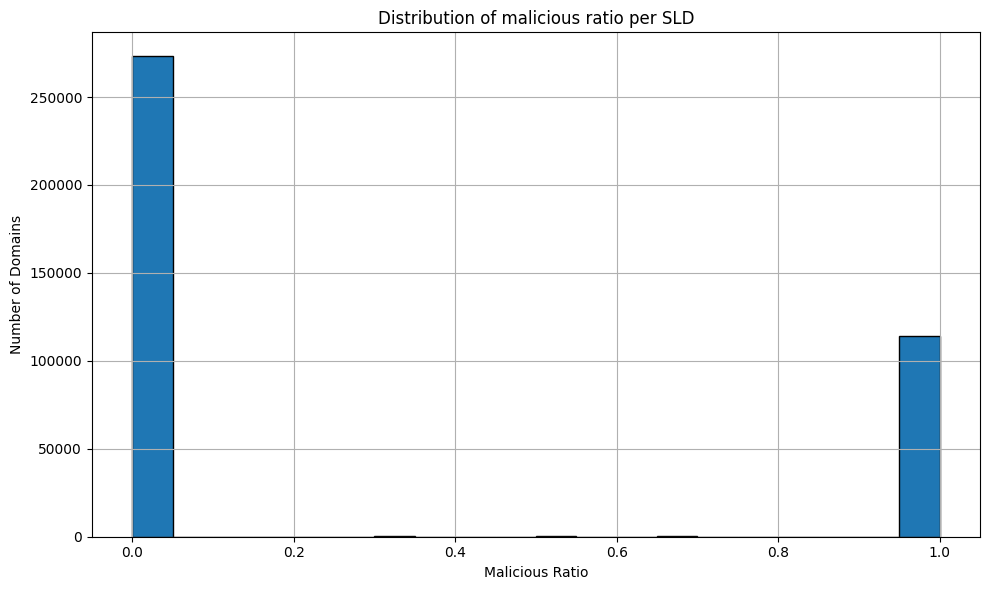

Number of domains in dataset: 388442


sld,benign,malicious,total_records,malicious_ratio
gvirabi,0,1922,1922,1.0
platino,0,1903,1903,1.0
patraglobal,0,1823,1823,1.0
69.167.151.209,0,1753,1753,1.0
justns,0,1657,1657,1.0
richardvorisek,0,1124,1124,1.0
iteem-927321,0,1001,1001,1.0
hacheyou,0,868,868,1.0
djfreshtech,0,840,840,1.0
shadetreetechnology,0,772,772,1.0


All malicious: 113976,  All benign: 273136, total: 388442
Domains with 100% malicious URLs: 113976 (29.34%)
Domains with 100% benign URLs:    273136 (70.32%)
Not always 100%: 0.34239345899774776 %


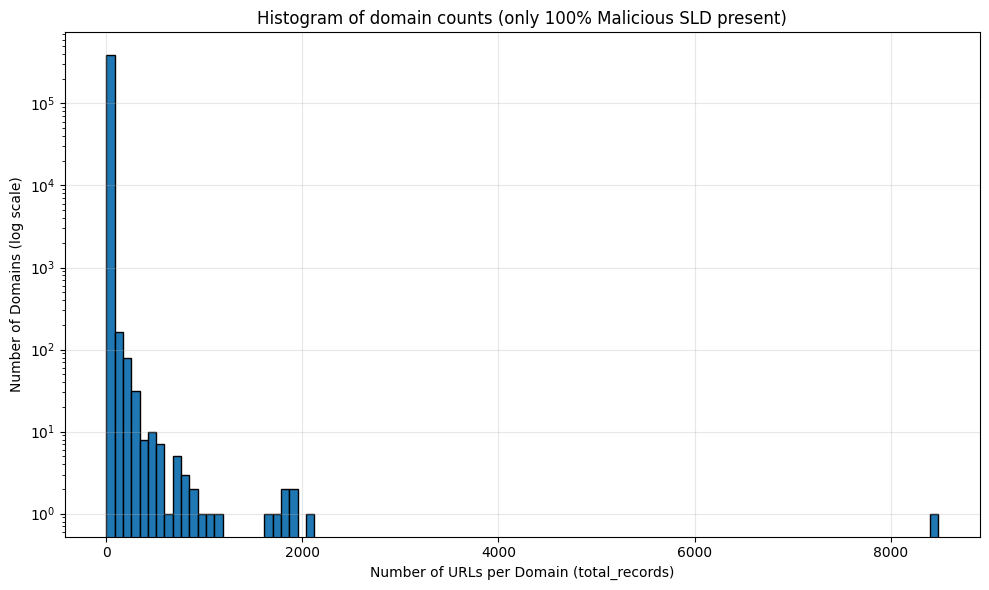

In [0]:
print_domain_statistics(datasets["grambeddings"])

=== mendeley ===


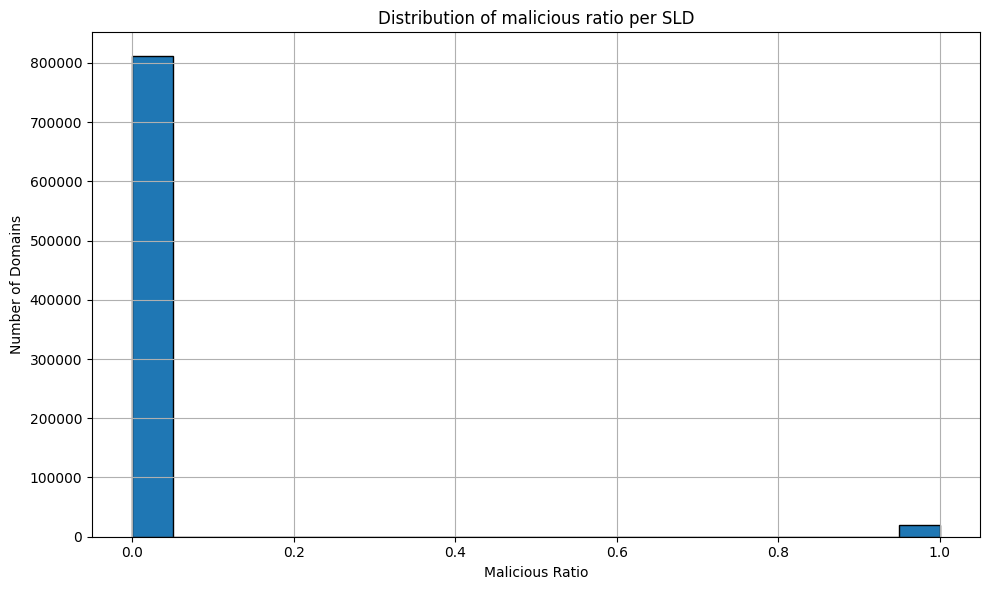

Number of domains in dataset: 831531


sld,benign,malicious,total_records,malicious_ratio
cherryboys,0,163,163,1.0
all-free-quality-pics,0,129,129,1.0
xyzbluebook,0,122,122,1.0
pornzite,0,107,107,1.0
tnasupermarket,0,106,106,1.0
thexxxarchive,0,97,97,1.0
avsring,0,81,81,1.0
sex-marks,0,77,77,1.0
worldsexguide,0,76,76,1.0
sexhosters,0,70,70,1.0


All malicious: 19627,  All benign: 810783, total: 831531
Domains with 100% malicious URLs: 19627 (2.36%)
Domains with 100% benign URLs:    810783 (97.50%)
Not always 100%: 0.13481157046459202 %


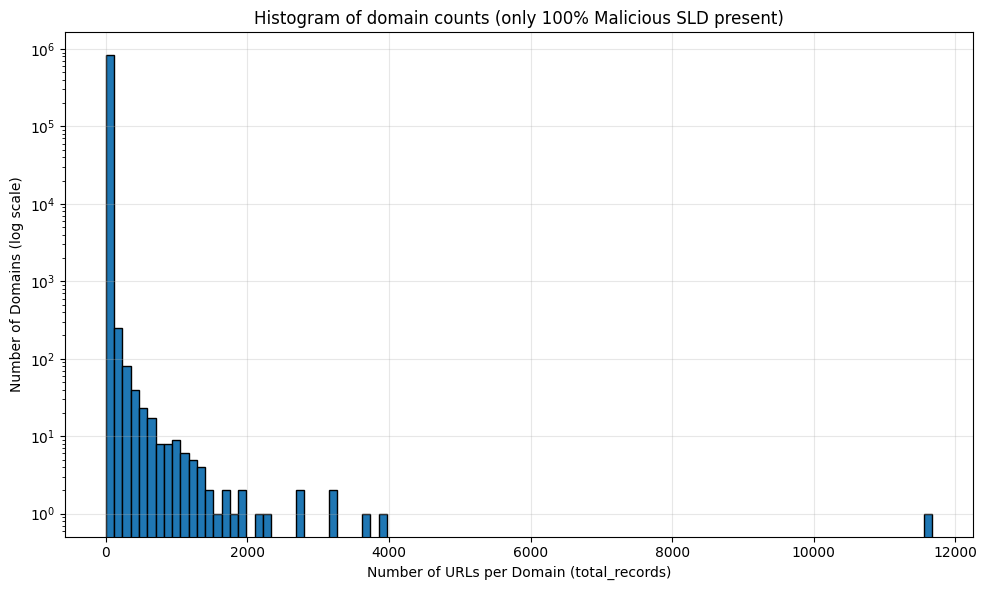

In [0]:
print_domain_statistics(datasets["mendeley"])

=== kaggle_binary ===


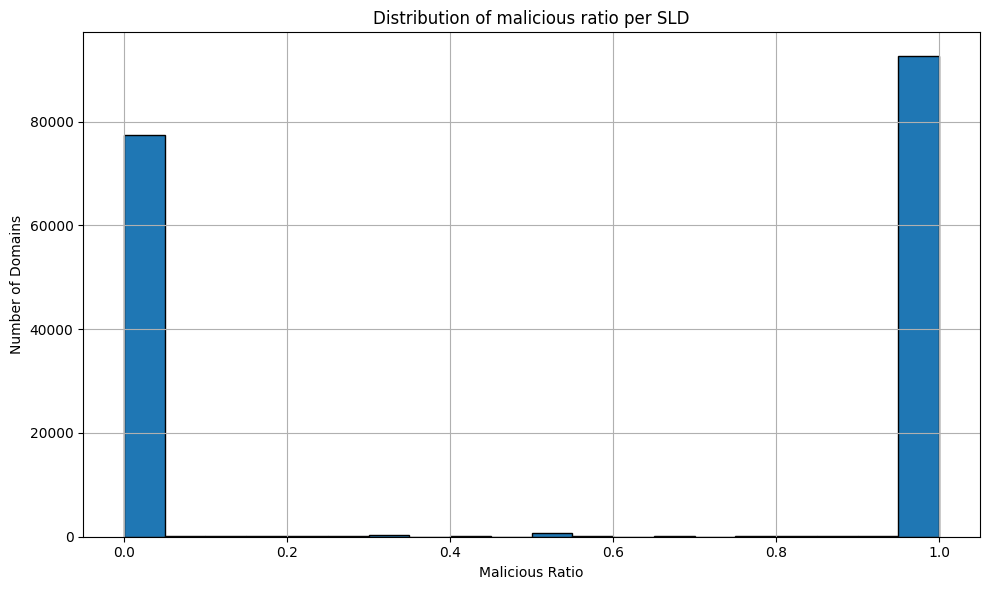

Number of domains in dataset: 172572


sld,benign,malicious,total_records,malicious_ratio
ietf,0,3212,3212,1.0
mixh,0,2889,2889,1.0
000webhostapp,0,2168,2168,1.0
apbfiber,0,1147,1147,1.0
pastehtml,0,946,946,1.0
sharepoint,0,582,582,1.0
toulousa,0,501,501,1.0
9779,0,395,395,1.0
mhcable,0,381,381,1.0
beget,0,370,370,1.0


All malicious: 92557,  All benign: 77257, total: 172572
Domains with 100% malicious URLs: 92557 (53.63%)
Domains with 100% benign URLs:    77257 (44.77%)
Not always 100%: 1.5981735159817347 %


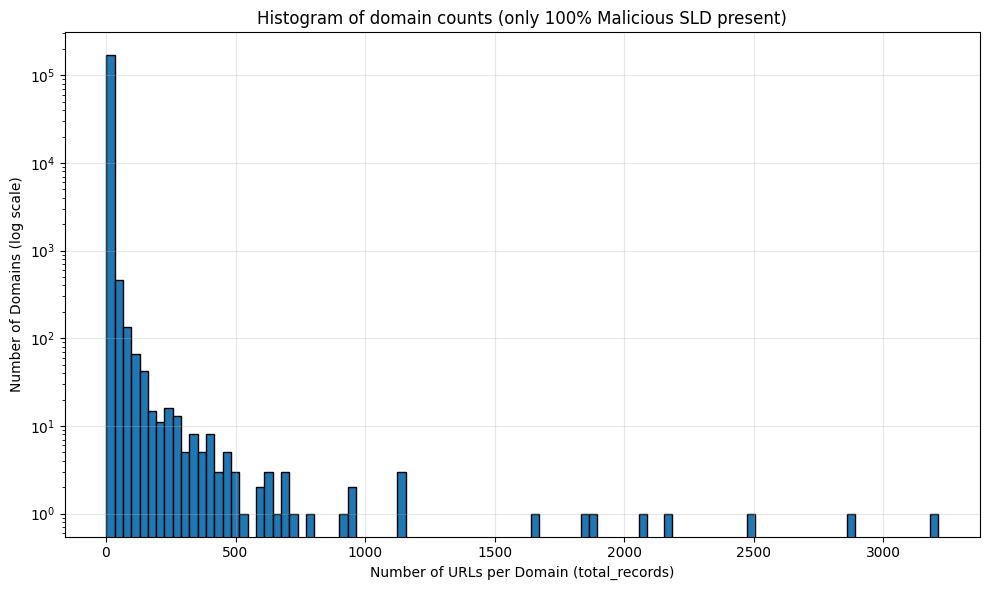

In [0]:
print_domain_statistics(datasets["kaggle_binary"])

=== kaggle_multiple ===


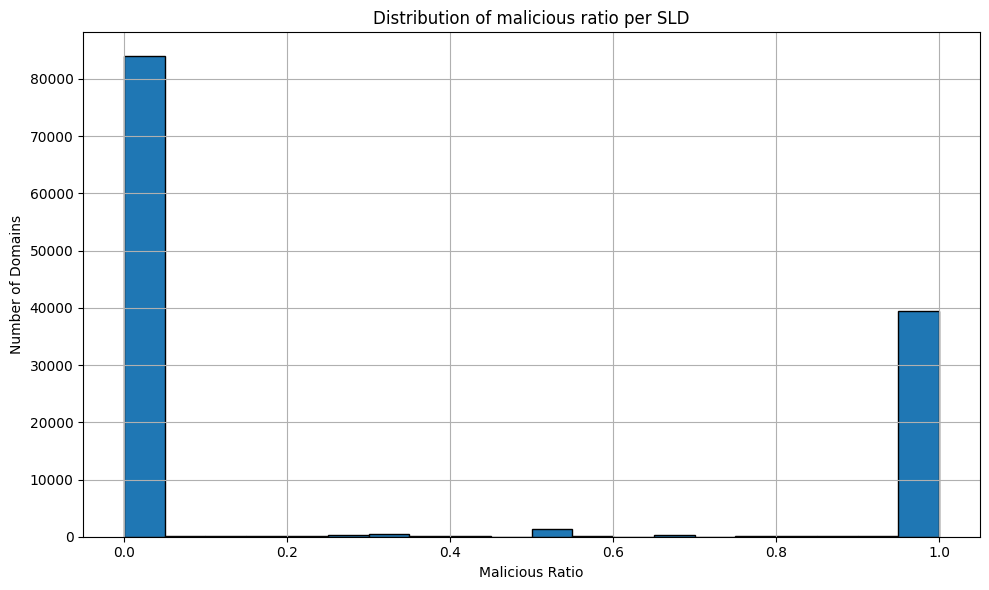

Number of domains in dataset: 126948


sld,benign,malicious,total_records,malicious_ratio
ietf,0,2573,2573,1.0
mixh,0,2314,2314,1.0
000webhostapp,0,955,955,1.0
apbfiber,0,910,910,1.0
toulousa,0,419,419,1.0
9779,0,326,326,1.0
sharepoint,0,305,305,1.0
beget,0,235,235,1.0
spdtextile,0,208,208,1.0
googleapis,0,194,194,1.0


All malicious: 39507,  All benign: 83821, total: 126948
Domains with 100% malicious URLs: 39507 (31.12%)
Domains with 100% benign URLs:    83821 (66.03%)
Not always 100%: 2.851561269181076 %


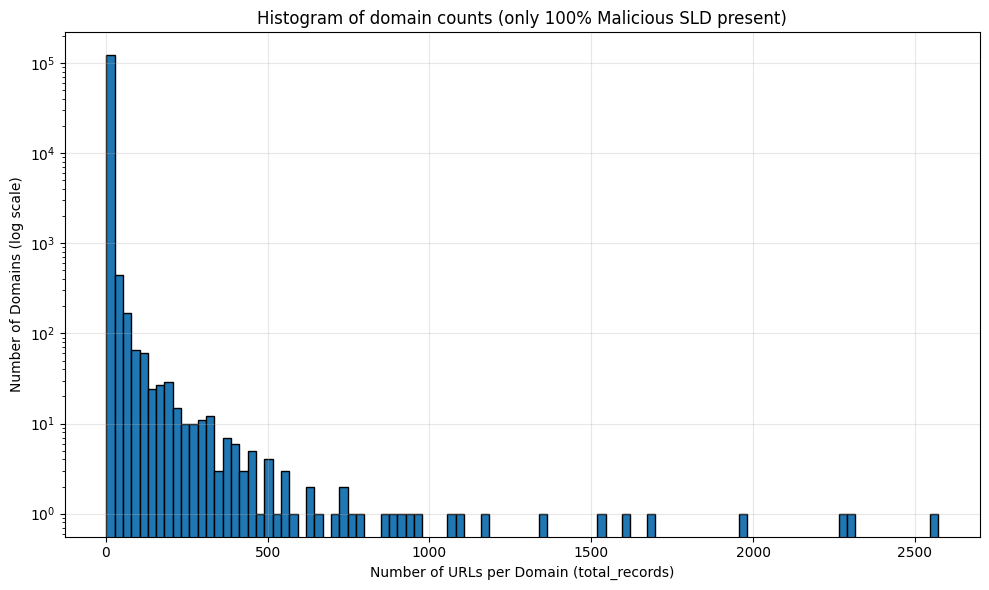

In [0]:
print_domain_statistics(datasets["kaggle_multiple"])

=== private_data ===


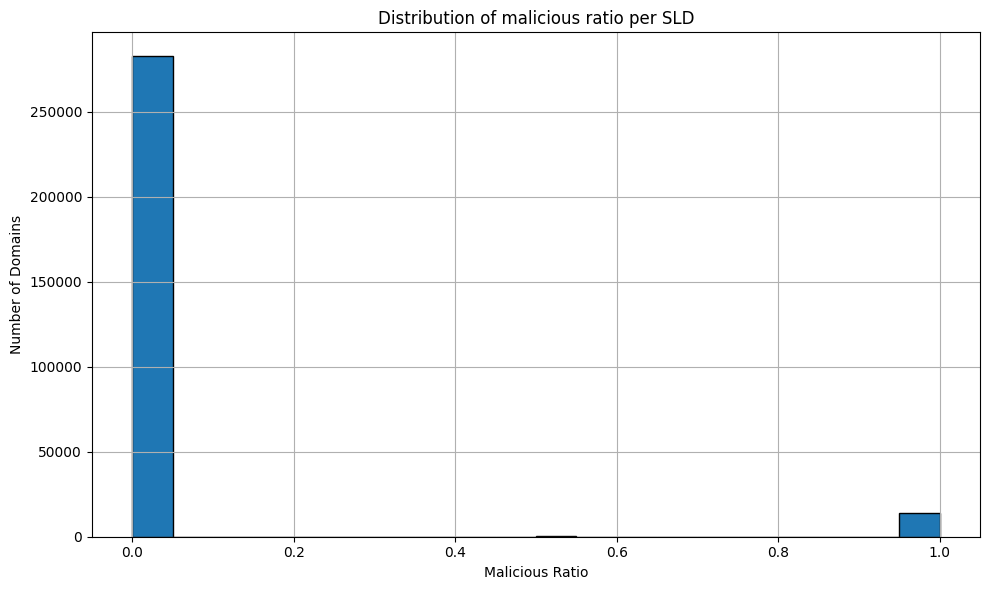

Number of domains in dataset: 297416


sld,benign,malicious,total_records,malicious_ratio
ipfs,0,8012,8012,1.0
mcwethyssportsbar,0,6221,6221,1.0
de-index,0,6193,6193,1.0
softwaresuggest-email,0,4523,4523,1.0
vyaav,0,4422,4422,1.0
tapestrynetworks,0,3115,3115,1.0
dudejafoundation,0,2939,2939,1.0
orangekids,0,2875,2875,1.0
139.224.15.219,0,2080,2080,1.0
202.74.109.148,0,1892,1892,1.0


All malicious: 13999,  All benign: 282351, total: 297416
Domains with 100% malicious URLs: 13999 (4.71%)
Domains with 100% benign URLs:    282351 (94.93%)
Not always 100%: 0.3584205288215827 %


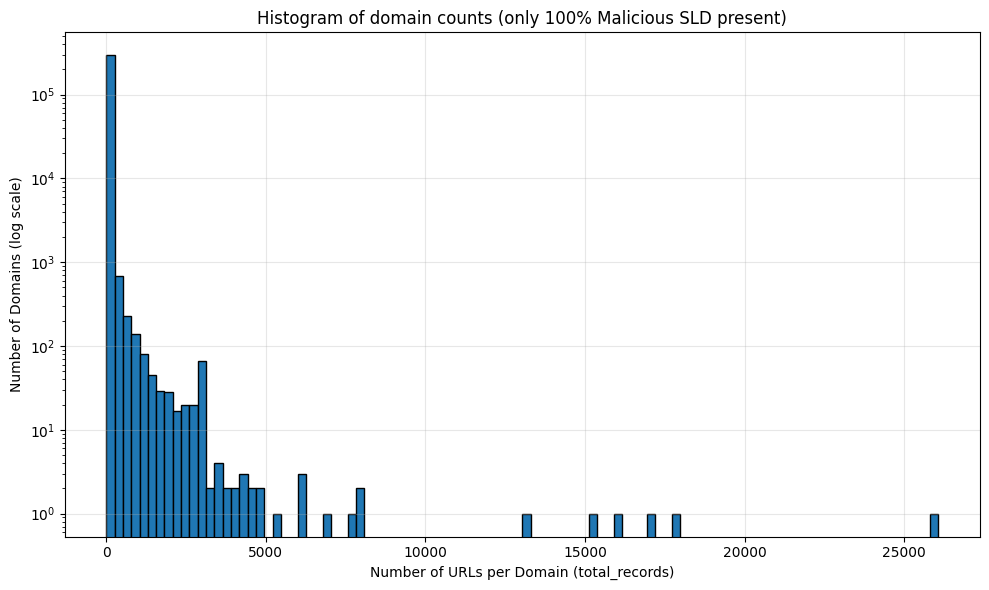

In [0]:
if not is_local_development():
    print_domain_statistics(datasets["private_data"])

=== joined ===


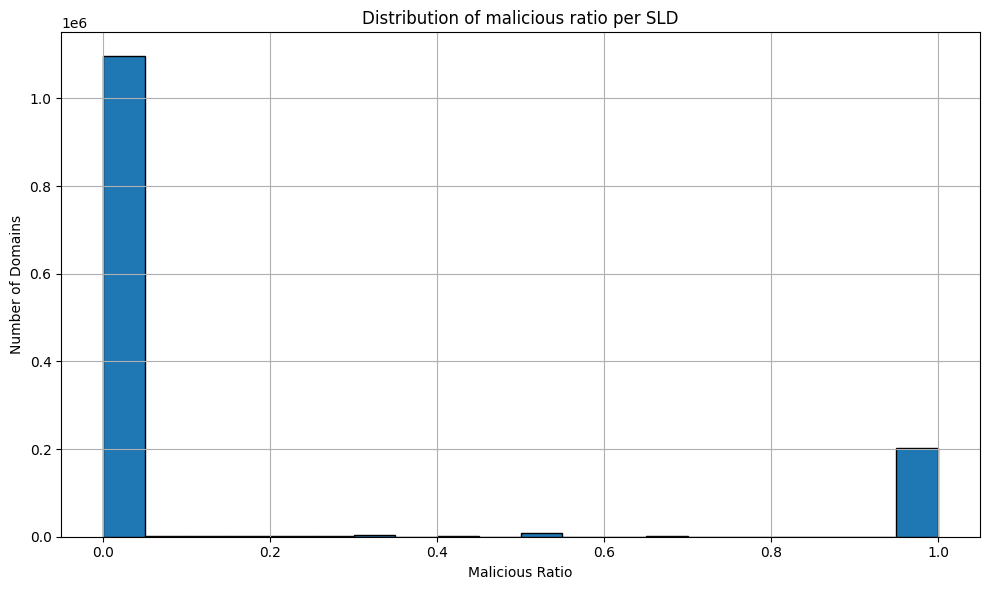

Number of domains in dataset: 1320127


sld,benign,malicious,total_records,malicious_ratio
mixh,0,2949,2949,1.0
gvirabi,0,1923,1923,1.0
platino,0,1903,1903,1.0
patraglobal,0,1823,1823,1.0
69.167.151.209,0,1754,1754,1.0
justns,0,1689,1689,1.0
apbfiber,0,1147,1147,1.0
richardvorisek,0,1124,1124,1.0
iteem-927321,0,1001,1001,1.0
pastehtml,0,946,946,1.0


All malicious: 202137,  All benign: 1094871, total: 1320127
Domains with 100% malicious URLs: 202137 (15.31%)
Domains with 100% benign URLs:    1094871 (82.94%)
Not always 100%: 1.751270900451246 %


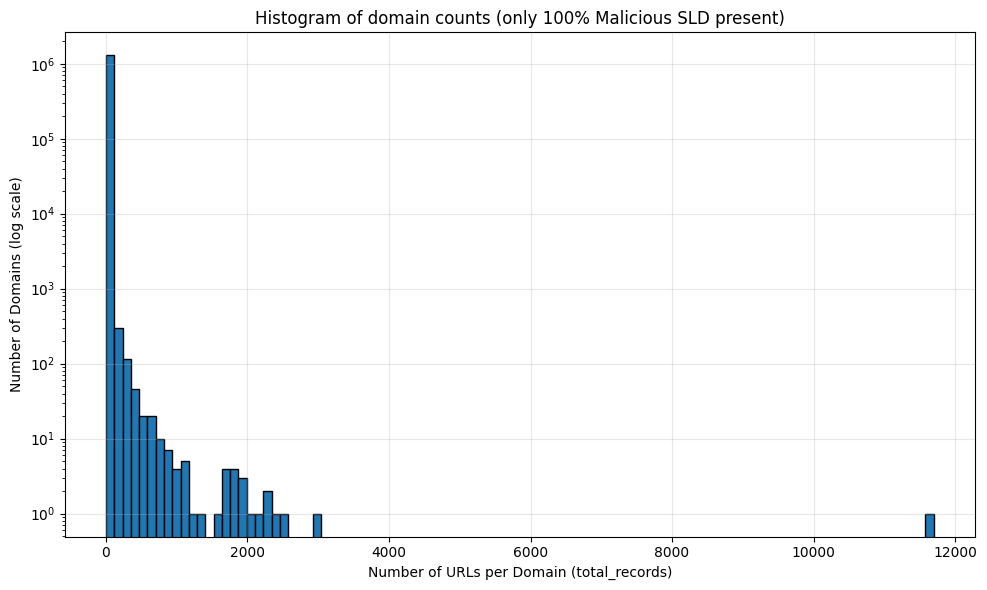

In [0]:
print_domain_statistics(datasets["joined"])

### SLD repetition
- we calculate the following
- gini index
    - Close to 0: SLDs are evenly distributed.
    - Close to 1: A few SLDs are extremely dominant.
- top-k dominance for k = 3,5,10
    - from 0 to 1 similar meaning as gini index
    - provides more granular insight
- median, mean number of repetitions

In [0]:
from utils.url_features import gini_coefficient

results = []
for ds in all_datasets["dataset"].unique():
    subset = all_datasets[all_datasets["dataset"] == ds]
    total = len(subset)
    freq_counts = subset["sld"].value_counts()
    gini = gini_coefficient(freq_counts.values)
    top3_ratio = freq_counts.head(3).sum() / total
    top5_ratio = freq_counts.head(5).sum() / total
    top10_ratio = freq_counts.head(10).sum() / total
    median = freq_counts.median()
    mean = freq_counts.mean()
    results.append(
        {
            "dataset": ds,
            "gini_index": f"{gini:.4f}",
            "top_3_ratio": f"{top3_ratio * 100:.2f}%",
            "top_5_ratio": f"{top5_ratio * 100:.2f}%",
            "top_10_ratio": f"{top10_ratio * 100:.2f}%",
            "median": f"{median:.2f}",
            "mean": f"{mean:.2f}",
        }
    )

result_df = pd.DataFrame(results).set_index("dataset")
display(result_df)

gini_index,top_3_ratio,top_5_ratio,top_10_ratio,median,mean
0.4582,4.74%,5.66%,6.97%,1.00,2.06
0.6482,5.04%,7.09%,10.33%,1.00,3.22
0.6787,5.60%,8.18%,11.84%,1.00,3.44
0.4434,6.30%,7.73%,9.72%,1.00,1.82
0.5147,3.44%,4.81%,7.09%,1.00,2.17
0.8661,3.23%,4.66%,7.47%,1.00,9.54


## Folds

In [0]:
from utils.dataset import analyze_folds

In [0]:
all_datasets_copy = []
for dataset_name in dataset_names:
    print(f"=== {dataset_name} ===")
    display(analyze_folds(dataset))

=== grambeddings ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


=== kaggle_binary ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


=== kaggle_multiple ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


=== mendeley ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


=== joined ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


=== private_data ===


fold,total,unique_domains,benign,benign_pct,malicious,malicious_pct,top_1,top_2,top_3
1.0,296978,31015,273269,92.01658035275341,23709,7.983419647246598,ravsend1 (8.2%),n-c4 (2.6%),canva (2.2%)
2.0,289023,30998,258626,89.48284392591593,30397,10.517156074084069,gstatic (9.0%),r2 (2.7%),farmersinsurance (2.6%)
3.0,307560,30882,264309,85.9373780725712,43251,14.062621927428795,box (5.8%),wordpress (5.0%),ru (3.2%)
4.0,260281,31105,236487,90.85834156161994,23794,9.141658438380059,bubbleapps (1.8%),vyaav (1.7%),live (1.4%)
5.0,288840,30990,260775,90.28354798504363,28065,9.716452014956376,163 (5.6%),wix (4.5%),de-index (2.1%)
6.0,297071,31966,263351,88.6491781425989,33720,11.350821857401092,googleapis (6.1%),amazonaws (3.6%),srv (1.0%)
7.0,311723,30913,285874,91.7077020303282,25849,8.292297969671791,google (12.4%),weebly (4.0%),tapestrynetworks (1.0%)
8.0,248426,31311,218466,87.94007068503296,29960,12.059929314967032,fujitsu (4.8%),ipfs (3.2%),walgreens (2.0%)
9.0,273325,31310,247994,90.73227842312266,25331,9.267721576877344,subway (2.2%),blogspot (2.1%),whatsapp (1.6%)
10.0,262820,31036,243280,92.56525378586105,19540,7.434746214138954,amazonaws (2.7%),gitlab (1.2%),azure (1.2%)


# String analysis

In [0]:
from utils.url_features import extract_all_vec

In [0]:
pd.set_option("display.max_columns", None)

In [0]:
features = extract_all_vec(all_datasets["url"])
result = pd.concat([all_datasets, features], axis=1)
result.groupby(["dataset", "label"]).mean(numeric_only=True)

fold  num_semicolons  num_underscores  \
dataset         label                                                  
private_data      benign     5.417176        0.206269         1.536730   
                malicious  5.275016        0.066435         0.831117   
grambeddings    benign     2.063105        0.034115         0.108946   
                malicious  1.936899        0.031403         0.289839   
joined          benign     1.982214        0.021118         0.150568   
                malicious  2.057574        0.056441         0.259104   
kaggle_binary   benign     1.953755        0.005341         0.454590   
                malicious  2.061235        0.107413         0.229921   
kaggle_multiple benign     1.992555        0.043640         0.474353   
                malware    2.111683        0.003288         0.128971   
                phishing   2.007799        0.065762         0.156691   
mendeley        benign     1.995857        0.020970         0.096778   
                malicious  2.034095        0.005168         0.117933   

                           num_question_marks  num_equals  num_ampersands  \
dataset         label                                                       
private_data      benign               0.466315    1.479172        0.945545   
                malicious            0.663171    1.132813        0.494122   
grambeddings    benign               0.066740    0.120593        0.052733   
                malicious            0.235098    0.587947        0.321589   
joined          benign               0.054690    0.088270        0.034376   
                malicious            0.204750    0.510412        0.298679   
kaggle_binary   benign               0.136821    0.212694        0.075952   
                malicious            0.182431    0.451016        0.300285   
kaggle_multiple benign               0.180863    0.322219        0.147035   
                malware              0.058652    0.168585        0.108978   
                phishing             0.098037    0.184481        0.089026   
mendeley        benign               0.033855    0.052899        0.020512   
                malicious            0.006225    0.008652        0.002599   

                               length  num_digits  non_alnum_cnt  hyphen_cnt  \
dataset         label                                                          
private_data      benign     186.473079   38.720126      17.599489    2.516188   
                malicious  121.641801   18.904332      12.817718    1.947464   
grambeddings    benign      46.430752    1.822514       8.683673    1.119306   
                malicious   86.209255   14.981677      11.827613    0.976727   
joined          benign      41.008294    1.332135       7.954491    0.513870   
                malicious   73.544862   11.056770      10.717800    0.834539   
kaggle_binary   benign      58.296684    3.263119      10.458403    1.450230   
                malicious   57.799303    6.011641       9.326434    0.594303   
kaggle_multiple benign      57.686216    5.603407       8.506421    1.835612   
                malware     46.554330   11.070372       9.397253    0.349207   
                phishing    45.976855    3.692487       6.778053    0.472829   
mendeley        benign      35.840997    0.786267       7.221389    0.149802   
                malicious   37.200286    0.291176       7.681553    0.838607   

                             at_cnt  digit_letter_ratio  urlentropy  \
dataset         label                                                 
private_data      benign     0.086787            0.345672    4.898869   
                malicious  0.376717            0.218079    4.715502   
grambeddings    benign     0.000548            0.047662    4.099045   
                malicious  0.032475            0.203287    4.457297   
joined          benign     0.000422            0.035490    4.034610   
                malicious  0.024462            0.186294    4.335705   
kaggle_binary   b

In [ ]:
for dataset_name in dataset_names:
    df = result[result["dataset"] == dataset_name]
    print(df["length"].describe().round(3))
    print()

# === grambeddings ===
# count    799993.000
# mean         66.322
# std          59.071
# min           9.000
# 25%          36.000
# 50%          49.000
# 75%          74.000
# max        7833.000
# Name: url_length, dtype: float64

# === kaggle_multiple ===
# count    436638.000
# mean         55.191
# std          43.944
# min           2.000
# 25%          31.000
# 50%          43.000
# 75%          67.000
# max        2175.000
# Name: url_length, dtype: float64

# === joined ===
# count    2862060.000
# mean          48.593
# std           39.577
# min            2.000
# 25%           29.000
# 50%           38.000
# 75%           55.000
# max         7833.000
# Name: url_length, dtype: float64

# === kaggle_binary ===
# count    556261.000
# mean         58.082
# std          39.542
# min           2.000
# 25%          36.000
# 50%          49.000
# 75%          69.000
# max        2314.000
# Name: url_length, dtype: float64

# === mendeley ===
# count    1514102.000
# mean          35.872
# std           14.440
# min           12.000
# 25%           26.000
# 50%           32.000
# 75%           42.000
# max          721.000
# Name: url_length, dtype: float64

# === private_data ===
# count        2836160
# mean         179.990
# std          291.134
# min            1.000
# 25%           63.000
# 50%          107.000
# 75%          192.000
# max       110511.000
# Name: url_length, dtype: float64